# Proyek Klasifikasi Gambar: Face Mask 
- **Nama:** Ginanti Riski
- **Email:** a788xbm186@devacademy.id
- **ID Dicoding:** a788xbm186

## Import Semua Packages/Library yang Digunakan

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os, shutil
import random
from pathlib import Path
import tensorflowjs as tfjs
from PIL import Image

## Data Preparation

### Data Loading

In [4]:
# Path awal
base_path = Path("/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset")
combined_path = Path("/kaggle/working/face")

# Buat folder combined
combined_path.mkdir(parents=True, exist_ok=True)

# Folder sumber yang akan digabung
subfolders = ['Train', 'Test', 'Validation']

# Loop untuk copy semua file ke folder combined
for folder in subfolders:
    source_path = base_path / folder
    for class_folder in source_path.iterdir():  # misal 'Apple Red 1', 'Banana', dll
        if class_folder.is_dir():
            target_class_folder = combined_path / class_folder.name
            target_class_folder.mkdir(parents=True, exist_ok=True)
            
            for image_file in class_folder.iterdir():
                target_file_path = target_class_folder / image_file.name
                
                # Hindari overwrite jika file sudah ada (bisa pakai hash atau rename kalau mau lebih advanced)
                if not target_file_path.exists():
                    shutil.copy(image_file, target_file_path)

print("Semua data berhasil digabung ke folder combined.")


Semua data berhasil digabung ke folder combined.


In [5]:
dataset_path = '/kaggle/working/face'

class_names = os.listdir(dataset_path)
total_images = 0

for cls in class_names:
    total_images += len(os.listdir(os.path.join(dataset_path, cls)))

print(f"Jumlah Kelas: {len(class_names)}")
print(f"Total Gambar: {total_images}")

Jumlah Kelas: 2
Total Gambar: 11792


### Data Preprocessinga

#### Split Dataset

In [6]:
def split_dataset(base_dir, output_dir, train_ratio=0.8, val_ratio=0.10, test_ratio=0.10):
    classes = os.listdir(base_dir)
    for cls in classes:
        img_files = os.listdir(os.path.join(base_dir, cls))
        img_files = [f for f in img_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(img_files)

        n_total = len(img_files)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)

        subsets = {
            'train': img_files[:n_train],
            'val': img_files[n_train:n_train+n_val],
            'test': img_files[n_train+n_val:]
        }

        for subset, files in subsets.items():
            subset_dir = os.path.join(output_dir, subset, cls)
            os.makedirs(subset_dir, exist_ok=True)
            for f in files:
                src = os.path.join(base_dir, cls, f)
                dst = os.path.join(subset_dir, f)
                shutil.copy(src, dst)

# Contoh pemanggilan
original_dir = '/kaggle/working/face'
split_output_dir = "/kaggle/working/face_split"

split_dataset(original_dir, split_output_dir)


In [12]:
train_dir = '/kaggle/working/face_split/train'
val_dir = '/kaggle/working/face_split/val'
test_dir = '/kaggle/working/face_split/test'

img_size = (100,100)      # Atau ganti sesuai ukuran yang kamu mau
batch_size = 32

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalisasi pixel
    rotation_range=30,        # Augmentasi: rotasi
    width_shift_range=0.2,    # Augmentasi: geser horizontal
    height_shift_range=0.2,   # Augmentasi: geser vertikal
    zoom_range=0.3,           # Augmentasi: zoom
    horizontal_flip=True,     # Augmentasi: flip horizontal
    vertical_flip=True,       # Augmentasi: flip vertikal
    shear_range=0.3,          # Augmentasi: shear
    fill_mode='nearest'       # Menentukan bagaimana mengisi ruang kosong setelah transformasi
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Hanya normalisasi untuk val/test set

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 9433 images belonging to 2 classes.
Found 1178 images belonging to 2 classes.
Found 1181 images belonging to 2 classes.


Class mapping: {'WithMask': 0, 'WithoutMask': 1}


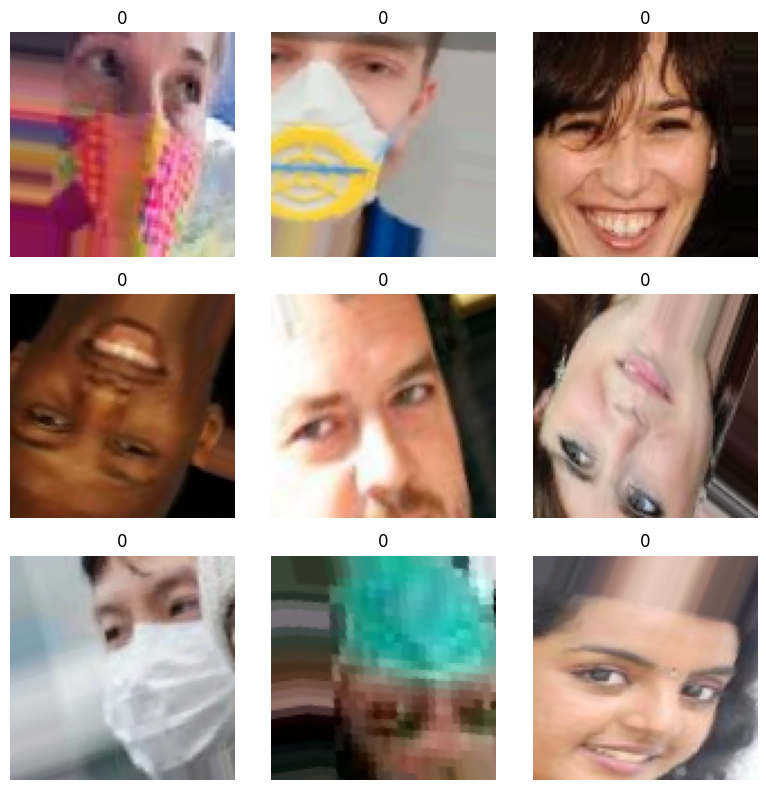

In [15]:
class_indices = train_generator.class_indices
print("Class mapping:", class_indices)

# Tampilkan contoh gambar
import matplotlib.pyplot as plt

x_batch, y_batch = next(train_generator)
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    plt.title(np.argmax(y_batch[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()


## Modelling

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,100, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),  # Tambahan
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),  # Tambahan
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_4 (Bat  (None, 98, 98, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 49, 49, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 batch_normalization_5 (Bat  (None, 47, 47, 32)       

In [18]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [19]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [20]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50


2025-04-22 10:40:17.253639: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1745318420.744100     637 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 [==============================] - 42s 116ms/step - loss: 0.3528 - accuracy: 0.8629 - val_loss: 0.7783 - val_accuracy: 0.7589 - lr: 0.0010
Epoch 2/50
295/295 [==============================] - 34s 114ms/step - loss: 0.2760 - accuracy: 0.8934 - val_loss: 0.3564 - val_accuracy: 0.8846 - lr: 0.0010
Epoch 3/50
295/295 [==============================] - 34s 114ms/step - loss: 0.2388 - accuracy: 0.9054 - val_loss: 0.8134 - val_accuracy: 0.6511 - lr: 0.0010
Epoch 4/50
295/295 [==============================] - 34s 114ms/step - loss: 0.2182 - accuracy: 0.9191 - val_loss: 0.1610 - val_accuracy: 0.9329 - lr: 0.0010
Epoch 5/50
295/295 [==============================] - 34s 114ms/step - loss: 0.2010 - accuracy: 0.9257 - val_loss: 0.1967 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 6/50
295/295 [==============================] - 34s 114ms/step - loss: 0.2061 - accuracy: 0.9257 - val_loss: 0.2763 - val_accuracy: 0.9151 - lr: 0.0010
Epoch 7/50
295/295 [==============================] - 34s 116ms

## Evaluasi dan Visualisasi

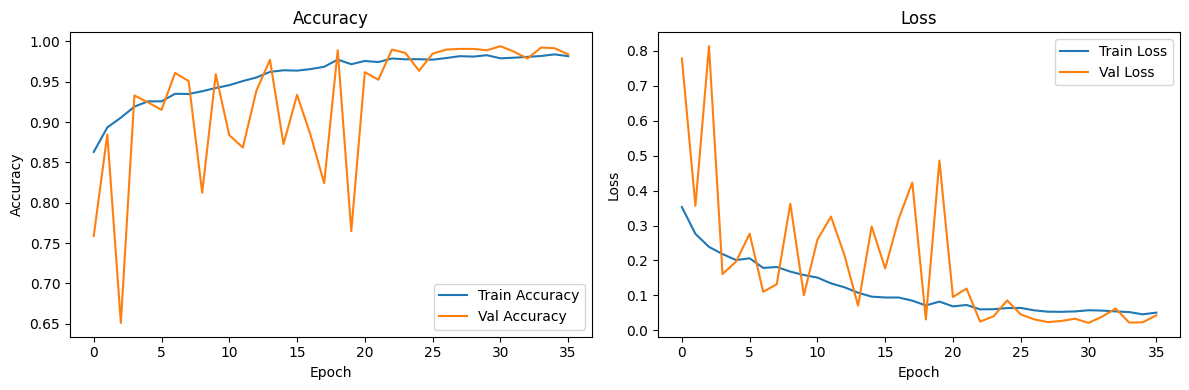

In [21]:
# Plot Akurasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Evaluasi di test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print("\n=== Evaluasi Model ===")
print(f"✔️ Train Accuracy     : {history.history['accuracy'][-1]*100:.2f}%")
print(f"✔️ Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
print(f"✔️ Test Accuracy      : {test_acc*100:.2f}%")
print(f"✔️ Test Loss          : {test_loss:.4f}")

37/37 [==============================] - 2s 53ms/step - loss: 0.0137 - accuracy: 0.9975

=== Evaluasi Model ===
✔️ Train Accuracy     : 98.17%
✔️ Validation Accuracy: 98.39%
✔️ Test Accuracy      : 99.75%
✔️ Test Loss          : 0.0137


## Konversi Model

In [23]:
# Membuat folder jika belum ada
os.makedirs("submission/tfjs_model", exist_ok=True)
os.makedirs("submission/tflite", exist_ok=True)
os.makedirs("submission/saved_model", exist_ok=True)


In [36]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]


In [ ]:
# Step 1: Buat concrete function
input_spec = tf.TensorSpec(shape=(1, 100, 100, 3), dtype=tf.float32)
concrete_func = tf.function(lambda x: model(x)).get_concrete_function(input_spec)

# Step 2: Konversi ke TFLite dari concrete function
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
tflite_model = converter.convert()

# Step 3: Simpan model tflite
with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

In [43]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]


In [45]:
converter.experimental_new_converter = False


In [46]:
class_labels = ['WithMask', 'WithoutMask']
with open("submission/tflite/label.txt", "w") as f:
    for label in class_labels:
        f.write(label + "\n")


In [32]:
# Mengonversi model ke format TensorFlow.js
import tensorflowjs as tfjs

# Mengonversi model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, "submission/tfjs_model")


In [27]:
!pip install tensorflowjs

In [33]:
model.save("submission/saved_model", save_format="tf")

In [47]:
import zipfile
import os

# Nama folder yang akan di-zip
folder_name = "submission"

# Nama file zip yang akan dibuat
zip_file_name = "/kaggle/working/submission.zip"

# Menggunakan zipfile untuk membuat file zip
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Menambahkan semua file dari folder ke dalam file zip
    for root, dirs, files in os.walk(folder_name):
        for file in files:
            zipf.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), folder_name))

print(f"Folder {folder_name} telah di-zip menjadi {zip_file_name}")


Folder submission telah di-zip menjadi /kaggle/working/submission.zip


## Inference (Optional)

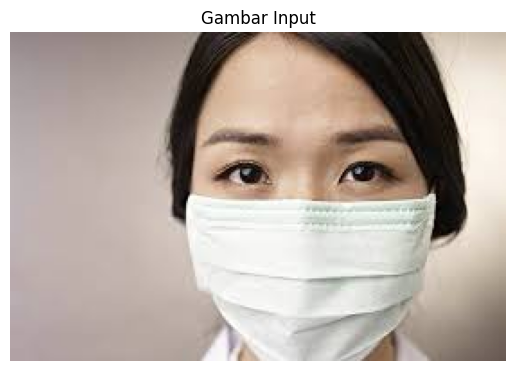

1/1 [==============================] - 0s 140ms/step
Prediksi: WithMask


In [54]:
# Load model
model = tf.keras.models.load_model("submission/saved_model")

image_path ='/kaggle/input/prediksi/mask.jpg'

# Fungsi prediksi dan menampilkan gambar
def predict_image(image_path):
    # Load gambar
    img = Image.open(image_path)
    img_resized = img.resize((100, 100))  # Sesuaikan dengan input model
    
    # Tampilkan gambar
    plt.imshow(img)
    plt.title("Gambar Input")
    plt.axis("off")
    plt.show()
    
    # Preprocessing gambar
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Prediksi
    prediction = model.predict(img_array)
    
    # Label mapping
    class_labels = ['WithMask', 'WithoutMask']
    predicted_label = class_labels[int(prediction[0][0] > 0.5)]

    print(f"Prediksi: {predicted_label}")

# Contoh pemanggilan
predict_image("/kaggle/input/prediksi/mask.jpg")

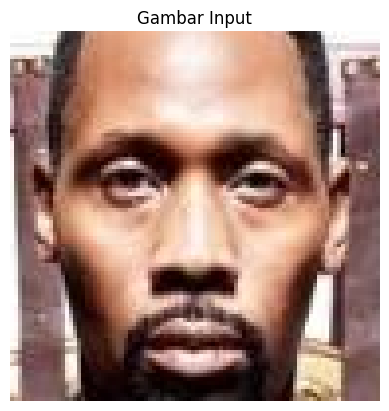

1/1 [==============================] - 0s 114ms/step
Prediksi: WithoutMask


In [58]:
# Load model
model = tf.keras.models.load_model("submission/saved_model")

image_path ='/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask/1.png'

# Fungsi prediksi dan menampilkan gambar
def predict_image(image_path):
    # Load gambar
    img = Image.open(image_path)
    img_resized = img.resize((100, 100))  # Sesuaikan dengan input model
    
    # Tampilkan gambar
    plt.imshow(img)
    plt.title("Gambar Input")
    plt.axis("off")
    plt.show()
    
    # Preprocessing gambar
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Prediksi
    prediction = model.predict(img_array)
    
    # Label mapping
    class_labels = ['WithMask', 'WithoutMask']
    predicted_label = class_labels[int(prediction[0][0] > 0.5)]

    print(f"Prediksi: {predicted_label}")

# Contoh pemanggilan
predict_image('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask/1.png')